# Project : Uber Supply Demand Gap

In [1]:
# import libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Understanding

The aim of analysis is to identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to improve the situation. As a result of our analysis, we should be able to present to the client the root cause(s) and possible hypotheses of the problem(s) and recommend ways to improve them.

## Data Understanding

There are six attributes associated with each request made by a customer:

- **Request id:** A unique identifier of the request
- **Time of request:** The date and time at which the customer made the trip request
- **Drop-off time:** The drop-off date and time, in case the trip was completed
- **Pick-up point:** The point from which the request was made
- **Driver id:** The unique identification number of the driver
- **Status of the request:** The final status of the trip, that can be either completed, cancelled by the driver or no cars available

In [2]:
# Load and read the uber dataset
uber = pd.read_csv("Uber Request Data.csv")
uber.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11-07-2016 11:51,11-07-2016 13:00
1,867,Airport,1.0,Trip Completed,11-07-2016 17:57,11-07-2016 18:47
2,1807,City,1.0,Trip Completed,12-07-2016 09:17,12-07-2016 09:58
3,2532,Airport,1.0,Trip Completed,12-07-2016 21:08,12-07-2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33,13-07-2016 09:25


In [3]:
uber['Driver id'].value_counts(dropna = False).sort_index()

1.0        13
2.0        13
3.0        14
4.0        15
5.0        13
         ... 
297.0      15
298.0      15
299.0      12
300.0       6
NaN      2650
Name: Driver id, Length: 301, dtype: int64

In [4]:
# check the no. the rows and columns of the dataset
uber.shape

(6745, 6)

In [5]:
# check the datatype of each column
uber.dtypes

Request id             int64
Pickup point          object
Driver id            float64
Status                object
Request timestamp     object
Drop timestamp        object
dtype: object

In [6]:
# change the datatype of 'Request timestamp' and 'Drop timestamp' from object to datetime.
uber['Request timestamp'] = pd.to_datetime(uber['Request timestamp'])
uber['Drop timestamp'] = pd.to_datetime(uber['Drop timestamp'])

In [7]:
uber.dtypes

Request id                    int64
Pickup point                 object
Driver id                   float64
Status                       object
Request timestamp    datetime64[ns]
Drop timestamp       datetime64[ns]
dtype: object

In [8]:
# check for the duplicated "Request id" .....('Request id' should be unique for each request made by customer.)
uber['Request id'].duplicated().sum()

0

In [9]:
# check the no. of missing value.
uber.isna().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

In [10]:
# check the % of NAN values columnwise
(uber.isna().sum()/uber.shape[0])*100

Request id            0.000000
Pickup point          0.000000
Driver id            39.288362
Status                0.000000
Request timestamp     0.000000
Drop timestamp       58.028169
dtype: float64

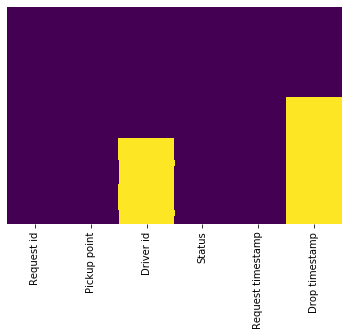

In [11]:
# check the missing value using Heatmap
sns.heatmap(uber.isna(),yticklabels = False, cbar = False,cmap = 'viridis' )

**Inference**
- More than 55% of Drop time is null because of Cancelled Trips(No cars available + Cancelled by the driver), which makes sense.
- Around 40% of Driver Id is null because of Cancelled Trips(No cars available), which makes sense.

In [12]:
# checking the year, month, date,weekday name present in our dataset
print(uber['Request timestamp'].dt.year.value_counts())
print('-'*40)
print(uber['Request timestamp'].dt.month.value_counts())
print('-'*40)
print(uber['Request timestamp'].dt.date.value_counts())
print('-'*40)
print(uber['Request timestamp'].dt.weekday_name.value_counts())

2016    6745
Name: Request timestamp, dtype: int64
----------------------------------------
7     4071
11    1367
12    1307
Name: Request timestamp, dtype: int64
----------------------------------------
2016-07-15    1381
2016-11-07    1367
2016-07-14    1353
2016-07-13    1337
2016-12-07    1307
Name: Request timestamp, dtype: int64
----------------------------------------
Wednesday    2644
Friday       1381
Monday       1367
Thursday     1353
Name: Request timestamp, dtype: int64


Text(0.5, 1, 'Status')

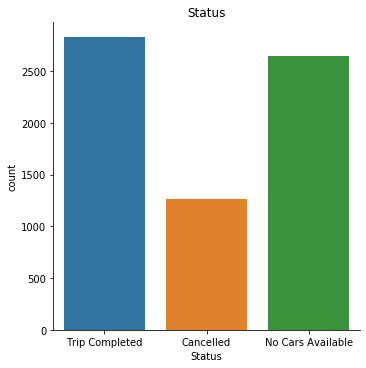

In [13]:
#checking the Status 
sns.catplot(x = 'Status',kind = 'count',data = uber)
plt.title('Status')

**We can clearly see from this plot that Uber is losing quite a lot of business due to shortage of available Cabs. The question that surfaces now is at what times during the day is the supply and demand gap most severe and if that is different for different days in the week**

In [14]:
# extract the date, time
uber['Request date'] = uber['Request timestamp'].dt.date
uber['Request hour'] = uber['Request timestamp'].dt.hour
uber['Drop date'] = uber['Drop timestamp'].dt.date
uber['Drop hour'] = uber['Drop timestamp'].dt.hour
uber['Request weekday'] = uber['Request timestamp'].dt.weekday_name

In [15]:
uber.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request date,Request hour,Drop date,Drop hour,Request weekday
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,2016-11-07,11,2016-11-07,13.0,Monday
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,2016-11-07,17,2016-11-07,18.0,Monday
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,2016-12-07,9,2016-12-07,9.0,Wednesday
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,2016-12-07,21,2016-12-07,22.0,Wednesday
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:00,2016-07-13 09:25:00,2016-07-13,8,2016-07-13,9.0,Wednesday


C:\Users\user\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


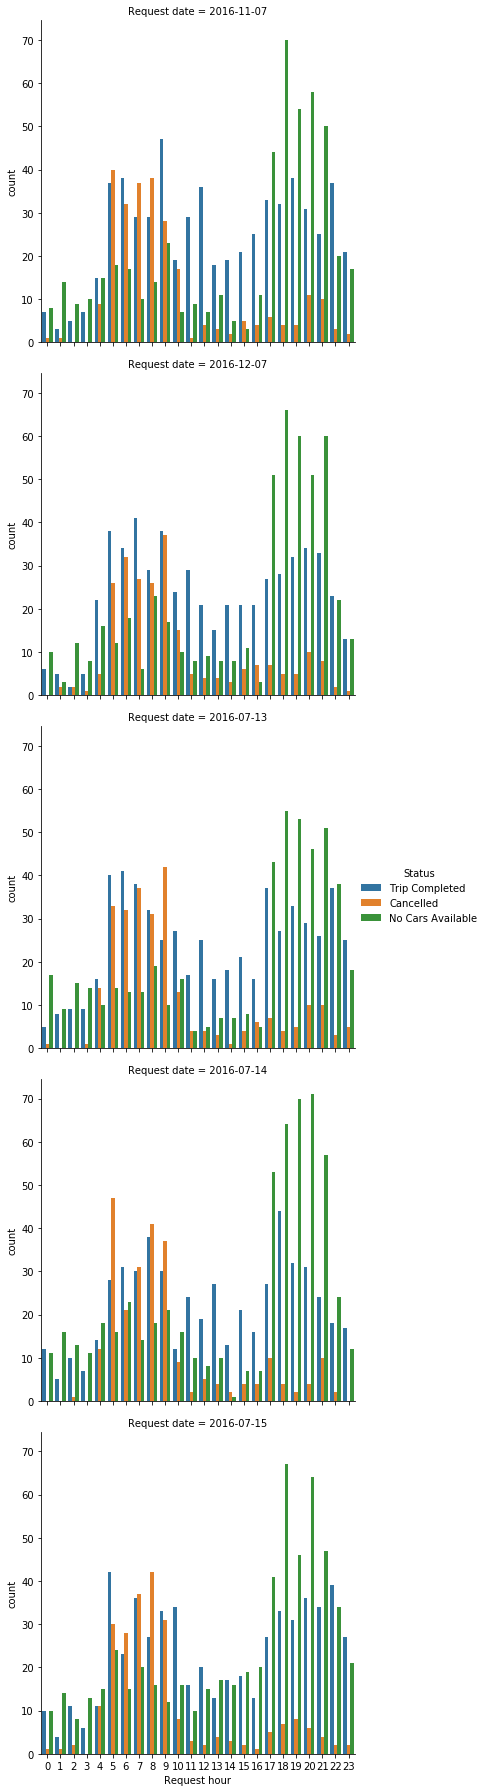

In [16]:
# factorplot of 'Request hour' and 'Request date' w.r.t to 'Status'
sns.factorplot(x = 'Request hour',hue = 'Status', row = 'Request date', kind = 'count', data = uber)

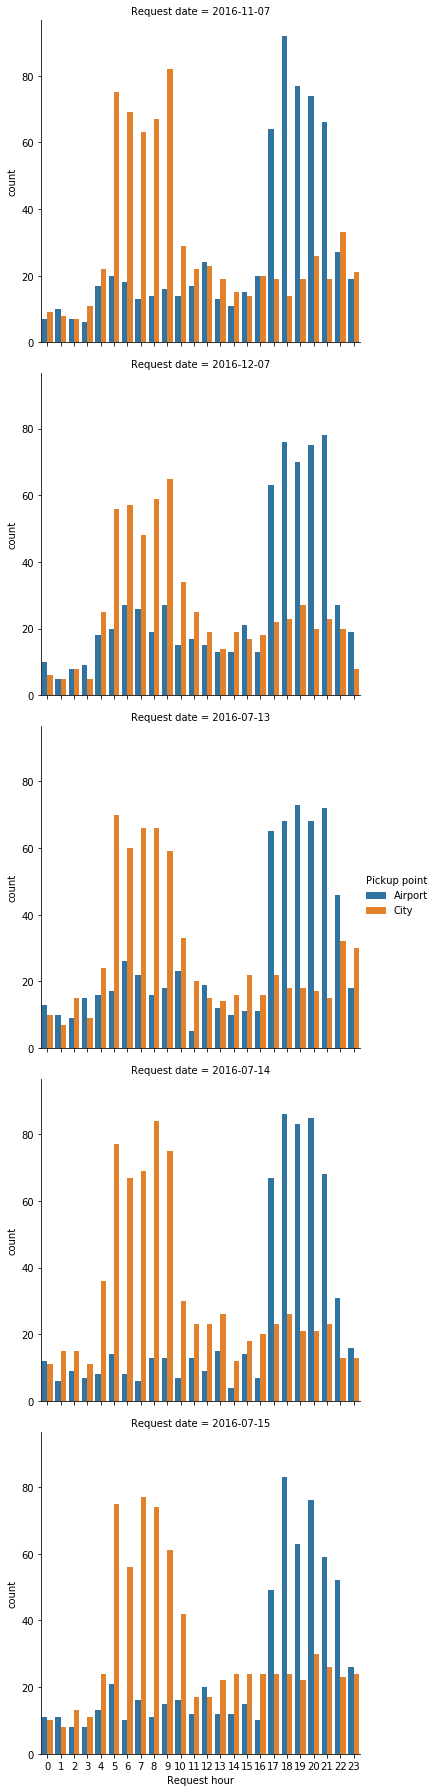

In [17]:
# factorplot of 'Request hour' and 'Request' w.r.t 'Pickup poiint'
sns.factorplot(x= 'Request hour', hue = 'Pickup point', row = 'Request date', kind = 'count', data = uber)

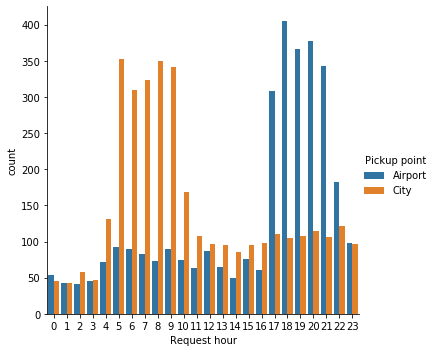

In [18]:
# aggregate count plot for all days w.r.t 'Pickup Point'
sns.factorplot(x= 'Request hour', hue = 'Pickup point', kind = 'count', data = uber)

In [19]:
# creating time slot for various time period of day
def time_period(x):
    if x < 5:
        return 'Pre Morning'
    elif 5 <= x < 10:
        return 'Morning rush'
    elif 10 <= x < 17:
        return 'Day time'
    elif 17 <= x < 22:
        return 'Evening rush'
    else:
        return 'Late night'
    

In [20]:
# apply the above function to all the rows of 'Request hour' column.
uber['time slot'] = uber['Request hour'].apply(lambda x: time_period(x))

In [21]:
uber['time slot'].value_counts()

Evening rush    2342
Morning rush    2103
Day time        1224
Pre Morning      578
Late night       498
Name: time slot, dtype: int64

<Figure size 1440x432 with 0 Axes>

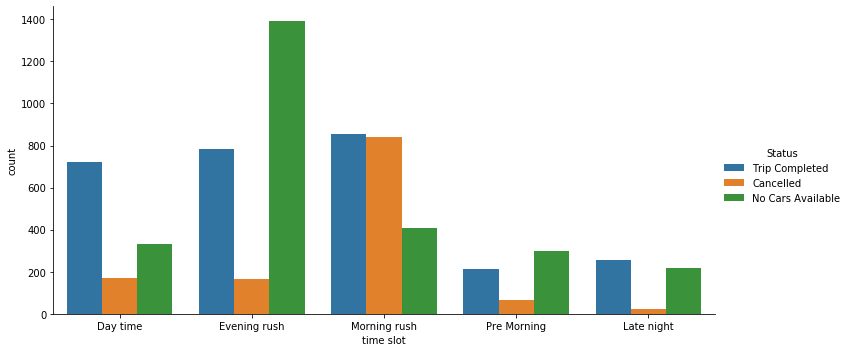

In [22]:
plt.figure(figsize = (20,6))
sns.catplot(x = 'time slot', hue = 'Status',kind = 'count', data = uber,aspect = 2)

## Lets look at the supply and demand at Morning rush hour

In [23]:
morning_rush  = uber[uber['time slot'] == 'Morning rush']

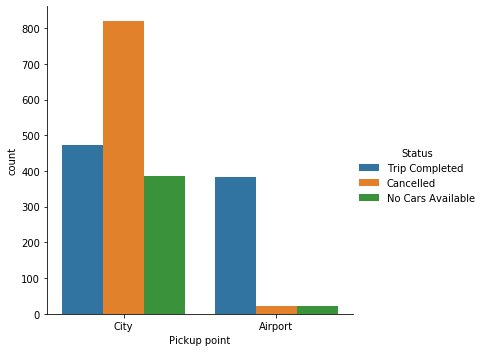

In [24]:
sns.catplot(x= 'Pickup point', hue = 'Status', kind = 'count', data = morning_rush)

In [25]:
# DEMAND
print('Cab Requirement at City during Morning rush :' ,morning_rush[morning_rush['Pickup point'] == 'City'].shape[0])
print('Cab Requirement at Airport during Morning rush :' ,morning_rush[morning_rush['Pickup point'] == 'Airport'].shape[0])

Cab Requirement at City during Morning rush : 1677
Cab Requirement at Airport during Morning rush : 426


In [26]:
# SUPPLY
print('City Morning Trip Completed :' ,morning_rush.loc[(morning_rush['Pickup point'] == 'City') & (morning_rush['Status'] == 
                                 'Trip Completed'), :].shape[0])

print('Airport Morning Trip Completed :' ,morning_rush.loc[(morning_rush['Pickup point'] == 'Airport') & (morning_rush['Status'] 
                                        == 'Trip Completed'), :].shape[0])

City Morning Trip Completed : 472
Airport Morning Trip Completed : 382


In [27]:
# cancellation of cab as per the pickup location during morning rush
city_cancel_mor = morning_rush.loc[(morning_rush['Pickup point'] == 'City') & (morning_rush['Status'] == 'Cancelled'),:]
print('City trip cancelled during morning rush :', city_cancel_mor.shape[0])

airport_cancel_mor = morning_rush.loc[(morning_rush['Pickup point'] == 'Airport') & (morning_rush['Status'] == 'Cancelled'),:]
print('Airport trip cancelled during morning rush :', airport_cancel_mor.shape[0])

City trip cancelled during morning rush : 820
Airport trip cancelled during morning rush : 23


In [28]:
# Unavailability of cabs as per the pickup loation during morning rush
city_unaval_mor = morning_rush.loc[(morning_rush['Pickup point'] == 'City') & (morning_rush['Status'] == 'No Cars Available'),:]
print('Cab Unavailability during morning rush at City :', city_unaval_mor.shape[0])

airport_unaval_mor = morning_rush.loc[(morning_rush['Pickup point'] == 'Airport') & (morning_rush['Status'] == 
                                    'No Cars Available'),:]
print('Cab Unavailability during morning rush at Airport :', airport_unaval_mor.shape[0])

Cab Unavailability during morning rush at City : 385
Cab Unavailability during morning rush at Airport : 21


## Lets look at the Supply and Demand Gap at Evening rush hour

In [29]:
evening_rush = uber[uber['time slot'] == 'Evening rush']

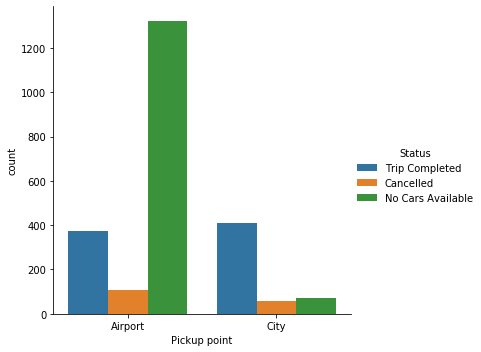

In [30]:
sns.catplot(x = 'Pickup point', hue = 'Status', kind = 'count', data = evening_rush)

In [31]:
# DEMAND
print('Cab Requirement at City during Evening rush :', evening_rush[evening_rush['Pickup point'] == 'City'].shape[0])

print('Cab Requirement at Airport during Evening rush :', evening_rush[evening_rush['Pickup point'] == 'Airport'].shape[0])

Cab Requirement at City during Evening rush : 542
Cab Requirement at Airport during Evening rush : 1800


In [32]:
# SUPPLY
print(' City Evening Trip Completed  :', evening_rush[(evening_rush['Pickup point'] == 'City') & 
                                        (evening_rush['Status'] == 'Trip Completed')].shape[0])

print(' Airport Evening Trip Completed  :', evening_rush[(evening_rush['Pickup point'] == 'Airport') & 
                                        (evening_rush['Status'] == 'Trip Completed')].shape[0])

 City Evening Trip Completed  : 411
 Airport Evening Trip Completed  : 373


In [33]:
# cancellation of cab as per the pickup location during evening rush
city_cancel_eve = evening_rush[(evening_rush['Pickup point'] == 'City') & (evening_rush['Status'] == 'Cancelled')]
print('City trip cancelled during evening rush :', city_cancel_eve.shape[0])

airport_cancel_eve = evening_rush[(evening_rush['Pickup point'] == 'Airport') & (evening_rush['Status'] == 'Cancelled')]
print('Airport trip cancelled during evening rush :', airport_cancel_eve.shape[0])

City trip cancelled during evening rush : 60
Airport trip cancelled during evening rush : 106


In [34]:
# Unavailability of cabs as per the pickup loation during evening rush
city_unaval_eve = evening_rush[(evening_rush['Pickup point'] == 'City') & (evening_rush['Status'] == 'No Cars Available')]
print('Cab Unavailability during evening rush at City :', city_unaval_eve.shape[0])

airport_unaval_eve = evening_rush[(evening_rush['Pickup point'] == 'Airport') & (evening_rush['Status'] == 
                                    'No Cars Available')]
print('Cab Unavailability during evening rush at Airport :', airport_unaval_eve.shape[0])

Cab Unavailability during evening rush at City : 71
Cab Unavailability during evening rush at Airport : 1321


## Pie Charts

In [35]:
# percentage breakup of status on the basis of pickup location('City') in morning rush
uber[(uber['Pickup point'] == 'City') & (uber['time slot'] == 'Morning rush')]['Status'].value_counts(normalize = True)

Cancelled            0.488968
Trip Completed       0.281455
No Cars Available    0.229577
Name: Status, dtype: float64

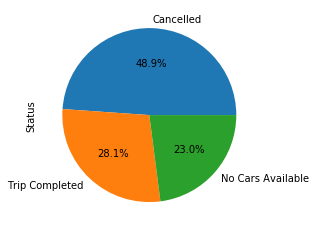

In [36]:
# pie chart of Status of trips @ Morning Rush where pickup point is City
uber[(uber['Pickup point'] == 'City') & (uber['time slot'] == 'Morning rush')]['Status'].value_counts(normalize = True).plot(kind = 'pie',autopct='%1.1f%%')

In [37]:
# percentage breakup of status on the basis of pickup location('Airport') in evening rush
uber[(uber['Pickup point'] == 'Airport') & (uber['time slot'] == 'Evening rush')]['Status'].value_counts(normalize = True)

No Cars Available    0.733889
Trip Completed       0.207222
Cancelled            0.058889
Name: Status, dtype: float64

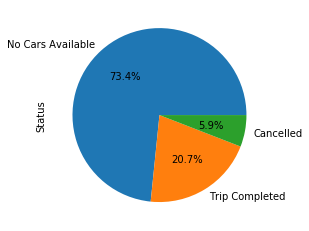

In [38]:
# pie chart of --Status of trips @ Evening Rush where pickup point is Airport
uber[(uber['Pickup point'] == 'Airport') & (uber['time slot'] == 'Evening rush')]['Status'].value_counts(normalize = True).plot(kind = 'pie',autopct='%1.1f%%')

# Recommendations

- **For the trips in the morning,** drivers can be incentivised to make those trips.
  - They could be given a bonus for each trip they complete from the city to the airport in the morning  rush. This will      ensure that less number of trips are cancelled.
  - Uber can pay for the gas mileage of drivers to come back to the city without a ride.
  - Uber can increase the demand at the airport to reduce idle time – by increased marketing and price  cuts for the passengers
- **For the evening, since the number of drivers is less, some of the ways are:**
  - Drivers can again be given a bonus to complete a trip from the airport in the evening. This will ensure  that the supply increases at the airport.
  - Uber can also pay drivers to come without a passenger to the airport
  - Another innovative way can be to pool the rides of passengers so that lesser number of cars can  serve more passengers.
